In [7]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import glob

imagesDir = 'images'
calibrationDir = 'images/calibration'

## Calibrating the camera

In [8]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6 * 9, 3), np.float32)
objp[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

# Arrays to store object points and image points from all the images.
objpoints = []  # 3d points in real world space
imgpoints = []  # 2d points in image plane.

# Make a list of calibration images
images = glob.glob(os.path.join(calibrationDir, 'calibration*.jpg'))

# Step through the list and search for chessboard corners
for filename in images:

    img = cv2.imread(filename)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    pattern_found, corners = cv2.findChessboardCorners(gray, (9, 6), None)

    if pattern_found is True:
        objpoints.append(objp)
        imgpoints.append(corners)


ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)




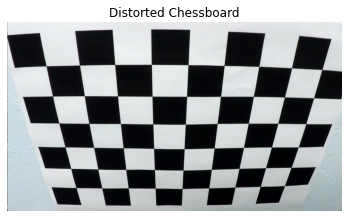

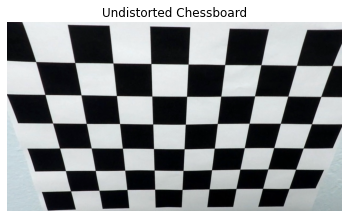

In [9]:
distorted_chessboard = cv2.imread(os.path.join(imagesDir, 'calibration_before.jpg'))
undistorted_chessboard = cv2.undistort(distorted_chessboard, mtx, dist, None, mtx)

plt.imshow(distorted_chessboard)
plt.title('Distorted Chessboard')
plt.axis('off')
plt.show()

plt.imshow(undistorted_chessboard)
plt.title('Undistorted Chessboard')
plt.axis('off')
plt.show()

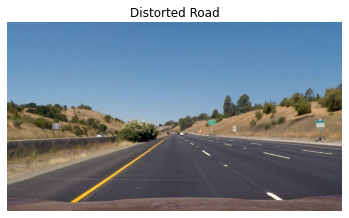

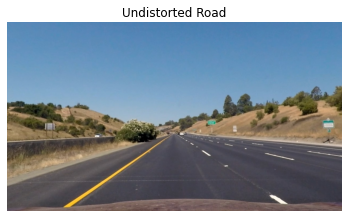

In [10]:
# test with a road image
distorted_road = cv2.imread(os.path.join(imagesDir, 'straight_lines1.jpg'))
distorted_road = cv2.cvtColor(distorted_road, cv2.COLOR_BGR2RGB)
img = cv2.undistort(distorted_road, mtx, dist, None, mtx)

plt.imshow(distorted_road)
plt.title('Distorted Road')
plt.axis('off')
plt.show()

plt.imshow(img)
plt.title('Undistorted Road')
plt.axis('off')
plt.show()

## Detect edges

In [11]:
# convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# apply Gaussian blur to reduce noise
blur = cv2.GaussianBlur(gray, (5, 5), 0)

# apply Canny edge detection
edges = cv2.Canny(blur, 50, 100)

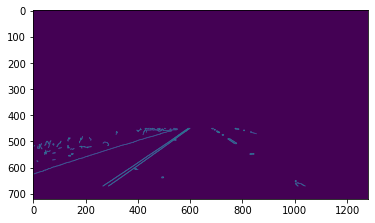

In [12]:
def region_of_interest(image):
   height = image.shape[0]
   width = image.shape[1]
   mask = np.zeros_like(image)
   triangle = np.array([[(0, 670), (0, 500), (250,450), (800,450), (width,height- 80), (width, 670)]], np.int32)
   cv2.fillPoly(mask, triangle, 255)
   masked_image = cv2.bitwise_and(image, mask)
   return masked_image

cropped_canny = region_of_interest(edges)

plt.imshow(cropped_canny)

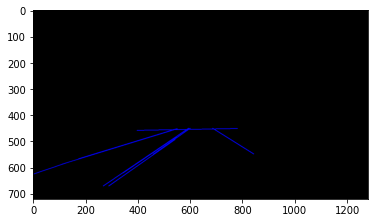

In [13]:
# perform Hough transform to detect lines
lines = cv2.HoughLinesP(cropped_canny, 1, np.pi/180, 50, minLineLength=100, maxLineGap=100)

# create a black image for visualization
vis = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)

# draw detected lines on the black image
for line in lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(vis, (x1, y1), (x2, y2), (0, 0, 255), 2)

plt.imshow(vis)

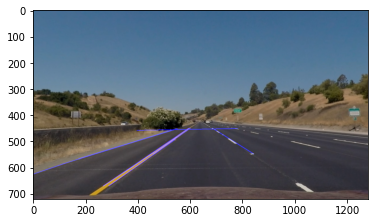

In [14]:
final_image = cv2.addWeighted(img, 0.8, vis, 1, 0)
plt.imshow(final_image)

In [15]:
def make_points(image, line):
   slope, intercept = line
   y1 = int(image.shape[0])
   y2 = int(y1*3/5)
   x1 = int((y1-intercept)/slope)
   x2 = int((y2-intercept)/slope)
   return [[x1, y1, x2, y2]]

def average_slope_intercept(image, lines):
   left_fit = []
   right_fit = []
   if lines is None:
      return None
   for line in lines:
      for x1, y1, x2, y2 in line:
         fit = np.polyfit((x1,x2), (y1,y2), 1)
         slope = fit[0]
         intercept = fit[1]
         if slope < 0:
            left_fit.append((slope,intercept))
         else:
            right_fit.append((slope,intercept))
   left_fit_average = np.average(left_fit, axis = 0)
   right_fit_average = np.average(right_fit, axis = 0)
   left_line = make_points(image, left_fit_average)
   right_line = make_points(image, right_fit_average)
   averaged_lines = [left_line, right_line]
   return averaged_lines

[[4, 720, 623, 432]]
[[1118, 720, 657, 432]]


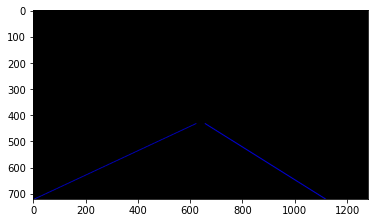

In [16]:
avg_lines = average_slope_intercept(img, lines)
line1 = avg_lines[0]
line2 = avg_lines[1]
print(line1)
print(line2)

offset = 50
#shift the lines to the left and right
#avg_lines[0][0][0] = avg_lines[0][0][0] - offset
#avg_lines[0][0][2] = avg_lines[0][0][2] - offset
#avg_lines[1][0][0] = avg_lines[1][0][0] + offset
#avg_lines[1][0][2] = avg_lines[1][0][2] + offset

vis = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)

for line in avg_lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(vis, (x1, y1), (x2, y2), (0, 0, 255), 2)

plt.imshow(vis)

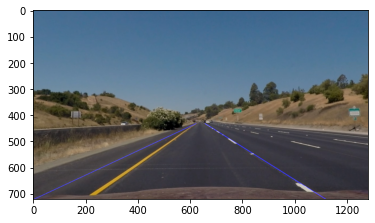

In [17]:
final_image = cv2.addWeighted(img, 0.8, vis, 1, 0)
plt.imshow(final_image)

## Create bird's eye image

In [18]:
line1 = avg_lines[0]
line2 = avg_lines[1]
print(line1)
print(line2)

#Get the starting and ending points of the lines
x1 = line1[0][0]
y1 = line1[0][1]
x2 = line1[0][2]
y2 = line1[0][3]
x3 = line2[0][0]
y3 = line2[0][1]
x4 = line2[0][2]
y4 = line2[0][3]

[[4, 720, 623, 432]]
[[1118, 720, 657, 432]]


In [19]:
def birdeye(img):
    h, w = img.shape[:2]
    src = np.float32([[x1, y1],   # bl
                    [x2, y2],   # tl
                    [x3, y3],   # br
                    [x4, y4]])  # tr

    dst = np.float32([[0, h],      # bl
                        [0, 0],    # tl
                        [w, h],    # br
                        [w, 0]])   # tr
    

    M = cv2.getPerspectiveTransform(src, dst)

    birdseye_img = cv2.warpPerspective(img, M, (w, h), flags=cv2.INTER_LANCZOS4)

    return birdseye_img, M



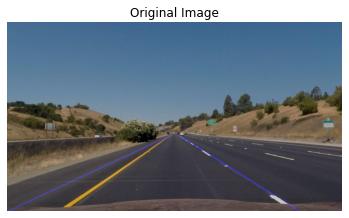

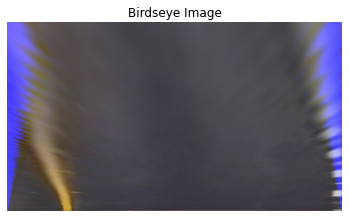

In [20]:
birdseye_img, M = birdeye(final_image)

plt.imshow(final_image)
plt.title('Original Image')
plt.axis('off')
plt.show()

plt.imshow(birdseye_img)
plt.title('Birdseye Image')
plt.axis('off')
plt.show()
